## Linear Regression

Inspiration for this question comes from: [1](https://mubaris.com/posts/linear-regression/) and [2](http://vxy10.github.io/2016/06/25/lin-reg-matrix/).

This is an implementation of the linear regression algorithm from scratch in Python. Linear regression maps feature vectors to a continuous value in the range $[-\infty,+\infty]$ by linearly combining the feature values. 

### Model Representation
Data will be represented as a dataframe or feature matrix.

Let our feature matrix be $X$ whose dimensions are $n \times m$, $\theta$ be a weight matrix of dimensions $m \times 1$, the bias vector $b$ a column vector of dimension $n\times 1$. Using these we can predict $\hat{Y}$
by the following relationship:

$$\hat{Y} = X\theta + b$$ 

### Data: Facebook posts metrics

This data contains features describing posts from a cosmetic brand's Facebook page. The authors use the following features: 

The dataset can be [found here](http://archive.ics.uci.edu/ml/datasets/Facebook+metrics). The authors of the dataset use the following features:

* Category,
* Page total likes: Number of people who have liked the company's page), 
* Type: Type of content (Link, Photo, Status, Video), 
* Post month: Month the post was published (January, February, March, …, December), 
* Post hour: Hour the post was published (0, 1, 2, 3, 4, …, 23) , 
* Post weekday: Weekday the post was published (Sunday, Monday, …,
Saturday) , 
* Paid: If the company paid to Facebook for advertising (yes, no)

to model: 

'Lifetime Post Total Reach', 'Lifetime Post Total Impressions', 'Lifetime Engaged Users', 'Lifetime Post Consumers',
'Lifetime Post Consumptions', 'Lifetime Post Impressions by people who have liked your Page', 'Lifetime Post reach by people who like your Page', 'Lifetime People who have liked your Page and engaged with your post', 'comment', 'like', 'share', 'Total Interactions'.


This model will focus on 'Total Interactions'. The feature space for this model will include: Category, Page total likes, Post month, Post hour, Post weekday, and Paid.





### Download Data


In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip -O ./Facebook_metrics.zip
import zipfile
with zipfile.ZipFile('./Facebook_metrics.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2023-01-29 02:20:26--  http://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16281 (16K) [application/x-httpd-php]
Saving to: ‘./Facebook_metrics.zip’

./Facebook_metrics. 100%[===================>]  15.90K  --.-KB/s    in 0.06s   

2023-01-29 02:20:26 (249 KB/s) - ‘./Facebook_metrics.zip’ saved [16281/16281]



### Read Data

In [2]:
import pandas as pd
import numpy as np
np.random.seed(1234)

# Shuffles the data in place 
def shuffle_data(data):
    np.random.shuffle(data)

# Normalizing all remaining columns
def normalize_col(col):
    return (col - col.min())/(col.max() - col.min())

# Read in the data
lr_dataframe = pd.read_csv('dataset_Facebook.csv',sep=';')
lr_dataframe.dropna(inplace=True)
columns_to_drop = ['Type','Lifetime Post Total Reach', 'Lifetime Post Total Impressions',
       'Lifetime Engaged Users', 'Lifetime Post Consumers',
       'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share']
lr_dataframe.drop(columns=columns_to_drop,inplace=True)

lr_dataframe = lr_dataframe.apply(normalize_col)

# Get entries as a numpy array
lr_data = lr_dataframe.values[:, :]

# Shuffle once for reproducibility
shuffle_data(lr_data)

# Show first 5 rows of the dataframe to check
lr_dataframe.head()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Total Interactions
0,0.978371,0.0,0.909091,1.000000,0.454545,0.0,0.008683
1,0.896850,0.0,0.636364,0.500000,0.363636,1.0,0.005052
2,0.651409,1.0,0.363636,0.833333,0.227273,0.0,0.015630
3,0.088185,1.0,0.000000,0.166667,0.272727,0.0,0.017051
4,0.064111,1.0,0.000000,1.000000,0.409091,0.0,0.027787


### Split Data

The data needs to be split into the training and testing sets for feature matrix $X$ and the target $Y$. 80% of the dataset will be used for training and 20% for testing.

In [3]:
# Sets x0 = 1 by appending a column of ones to account for the bias term.
# Returns augmented matrix.
def bias_trick(X):
  x_0 = np.ones((len(X), 1), dtype=int)
  X = np.hstack((x_0, X))
  return X

# Separates feature vectors and targets in the dataset. 
# Returns X as feature matrix and Y as vector of targets to predict.
def separate_data(data):
  X_no_bias = data[:,:-1]
  X = bias_trick(X_no_bias)
  Y = data[:,-1]
  return X, Y

# Splits the data into a training and testing set for X and Y. Returns the split data.
def train_test_split(data, train_size=.80):
    train = int(len(data)*train_size)
    X, Y = separate_data(data)
    X_train = X[:train]
    y_train = Y[:train]
    X_test = X[train:]
    y_test = Y[train:]
    return X_train, y_train, X_test, y_test

### Training and Testing the Model

The Mean Squared Error (MSE) will be used as a way to measure the performance of the model. In order to do that, the derivative of the MSE will also be used to minimize the error.

#### Mean Squared Error
The model will compute $\theta$ such that the MSE is minimized (the 1/2 factor makes the derivation easier). 

Let the MSE be a function of $\theta, J(\theta)$:

$$J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2$$

where, $\theta$ is the vector of weights computed to solve the equation:
$$\hat{y} = X \theta = z$$

In an expanded form, the same equation is:

$$\hat{y} = X \theta =
\begin{bmatrix}
    X_{1,0}\theta_0 + X_{1,1}\theta_1 + \cdots + X_{1,d}\theta_d  \\
    X_{2,0}\theta_0 + X_{2,1}\theta_1 + \cdots + X_{2,d}\theta_d  \\
    \vdots   \\
    X_{n,0}\theta_0 + X_{n,1}\theta_1 + \cdots + X_{n,d}\theta_d 
\end{bmatrix} =
\begin{bmatrix}
    z_1  \\
    z_2  \\
    \vdots   \\
    z_{n}
\end{bmatrix}$$

again where $X$ is the feature matrix, $\theta$ is the weight vector, and $z$ and $\hat{y}$ both represent the predicted value vector.

#### Derivative of Mean Squared Error
The derivative of the MSE is 

$$\frac{\partial}{\partial\theta_j}J(\theta) = \frac{1}{n} \sum_{i=1}^{n} ( \hat{y_i} - y_i)x_{i,j}$$

Now, combine MSE and derivative of MSE for a gradient descent algorithm to train the model.

In [4]:
# Calculate the mean squared error bewteen the predicted values and target values. 
# Returns vector of the error values.
def mse(y_pred, y_true):
  return (1/(2*(len(y_pred))) * np.sum((y_pred - y_true)**2))

# Calculate the derivative of the mean squared error. 
# Returns a vector of derivations of MSE.
def mse_derivative(X,y,theta):
  
  # h is the predicted value vector
  h = np.dot(X, theta)
  return ((1/len(X)) * np.dot((h - y), X))

'''
Move one step with gradient descent. 
X is feature matrix, y is the target value vector,
theta is the weight vector, alpha is the learning rate.
Returns updated theta vector.
'''
def gradient_descent_step(X,y, theta, alpha):

  # update theta vector
  theta = theta - (alpha * mse_derivative(X, y, theta))
  return theta

# Combine all the pieces to calculate the linear regression. 
# Returns theta, train, and test error vectors.
def linear_regression(data, num_epochs=30000, alpha=0.00005):
    # Get training and testing set by calling train_test_split()
    X_train, y_train, X_test, y_test = train_test_split(data)

    # Record training and test errors in lists
    train_errors= []
    test_errors= []

    # Define theta
    theta = np.zeros((X_train.shape[1]))

    # Carry out training loop
    for i in range(num_epochs):
        train_error = mse(np.dot(X_train, theta), y_train)
        train_errors.append(train_error)

        test_error = mse(np.dot(X_test, theta), y_test)
        test_errors.append(test_error)

        # Do gradient descent on the training set
        theta = gradient_descent_step(X_train, y_train, theta, alpha)
    return theta, train_errors, test_errors

### Train and visualize results



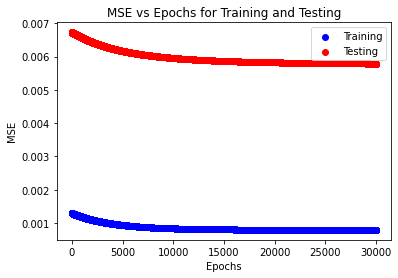

In [5]:
# Carry out training task
theta, train_errors, test_errors = linear_regression(lr_data)

import matplotlib.pyplot as plt
# Plot the training error and test error for different epochs (iterations of the
# algorithm). Your plot be MSE error vs epochs.
epochs = range(30000)
a = plt.scatter(epochs, train_errors, color='blue')
b = plt.scatter(epochs, test_errors, color='red')
plt.title('MSE vs Epochs for Training and Testing')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend((a, b), ('Training', 'Testing'))
plt.show()

### Evaluation

The model did well simply based on the graph. The training MSE seems to end up around 0.001 and the testing MSE seems to end around 0.0006 after 30000 iterations. The model seems to be well optimized after about 10000 iterations, which is 1/3 of the total epochs.